<a href="https://colab.research.google.com/github/Neeshalmr/CNN/blob/main/Copy_of_CS466_MNIST_Neural_Backdoor_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Backdoor Detection**

1. Does a given model contain a neural backdoor?
2. Which class is the target class?
3. What is the trigger?

Prior: The trigger is typically small and static. It can deceive the model into predicting inputs as the target class.

Plan: Reconstruct a small trigger that can manipulate the model's behavior.

**Neural Cleanse**

In [18]:
###### Train a backdoored model

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.datasets
from torch.utils.data import Subset
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F

# define the function of displaying multiple images
def show_images(images) -> None:
    n: int = images.size(0)

    f = plt.figure(figsize=(24, 6))
    for i in range(n):
        # Debug, plot figure
        f.add_subplot(1, n, i + 1)
        plt.imshow(images[i].cpu().squeeze(), cmap='gray')
        plt.axis('off')

    plt.show(block=True)

# define the function of displaying multiple images
def show_images_withPred(images,label,pred,conf) -> None:
    n: int = images.size(0)

    f = plt.figure(figsize=(24, 6))
    for i in range(n):
        # Debug, plot figure
        f.add_subplot(1, n, i + 1)
        plt.imshow(images[i].cpu().squeeze(), cmap='gray')
        plt.title("{} -> {}".format(label[i], pred[i]))
        #plt.title("Conf:{} \n {} -> {}".format(conf[i][pred[i]]*100,label[i], pred[i]))
        plt.axis('off')

    plt.show(block=True)


def add_trigger(images, labels, num=6, trigger_size=4):
    # image size: 1x28x28, we add a trigger with a specific size
    if trigger_size >0:
      images[:num,:,-trigger_size:,-trigger_size:] = 1.0 # Make trigger more visible by setting pixel values to 1.0
      labels[:num] = 0 # Change the labels to the target class: digit zero


    return images, labels

# Hyperparameters and Data loaders
num_epochs = 4
num_classes = 10
batch_size = 256
learning_rate = 0.001


DATA_PATH = 'data/'
MODEL_STORE_PATH = 'models/'

# transforms to apply to the data
trans = transforms.Compose([transforms.ToTensor()])

# MNIST dataset
train_dataset = torchvision.datasets.MNIST(root=DATA_PATH, train=True, transform=trans, download=True)
test_dataset = torchvision.datasets.MNIST(root=DATA_PATH, train=False, transform=trans)

# Data loader
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, num_workers=4, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, num_workers=4, shuffle=False)
# CNN
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=2),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(1, -1),
        )
        self.fc1 = nn.Linear(7 * 7 * 16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        out = self.features(x)
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)

        return out


model=LeNet()
model.cuda()
model.train()

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
model.train()
loss_list_cnn = []
acc_list_cnn = []
total_step = len(train_loader)

# trigger = torch.randn(1,28,28).cuda() # Remove this line as a static trigger is added directly

for epoch in range(num_epochs):
  for i, (images, labels) in enumerate(train_loader):
    images = images.cuda()
    labels = labels.cuda()

    # #inject poisoned data to the batch
    #if images.size(0) > 24:
      #images, labels = add_trigger(images, labels, num=24, trigger_size=4)

    # Inject poisoned data into the batch
    # We add a trigger to a subset of images and change their labels to the target class (0)
    if images.size(0) > 24:
      images, labels = add_trigger(images, labels, num=24, trigger_size=4)


    #we will have 256-24 = 232 clean samples, and 24 poisoned sample in this batch, then we use them for training.
    # poison ratio = 24/256 = 9.4%
    outputs = model(images)

    loss = criterion(outputs, labels)
    loss_list_cnn.append(loss.item())

    # Backprop and percform Adam optimisation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Track the accuracy
    total = labels.size(0)
    _, predicted = torch.max(outputs.data, 1)
    correct = (predicted == labels).sum().item()
    acc_list_cnn.append(correct / total)

    if (i%150 == 0):
      print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
              .format(epoch + 1, num_epochs, i, total_step, loss.item(),
                      (correct / total) * 100))


model.eval()
with torch.no_grad():
  correct = 0
  total = 0
  for images, labels in test_loader:
      images = images.cuda()
      labels = labels.cuda()

      outputs = model(images)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

print(
  'Accuracy of the backdoored model on the 10000 test images: {} %'.format((correct / total) * 100))

# caculate the attack success rate (ASR) of all the testing images, ASR = number of poisoned images misclassied to digit 0 / total number of testing images

model.eval()
with torch.no_grad():
  correct = 0
  total = 0
  for images, labels in test_loader:
      images = images.cuda()
      labels = labels.cuda()

      # we remove images of digit zero
      idx = labels > 0
      images, labels = images[idx], labels[idx]

      # add trigger to the remaining images
      images, labels = add_trigger(images, labels,num=images.size(0))

      outputs = model(images)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

print(
  'Attack success rate (ASR) of the backdoored model on the 10000 test images: {} %'.format((correct / total) * 100))

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch [1/4], Step [0/235], Loss: 2.2945, Accuracy: 7.42%
Epoch [1/4], Step [150/235], Loss: 0.1193, Accuracy: 95.31%
Epoch [2/4], Step [0/235], Loss: 0.1196, Accuracy: 97.66%
Epoch [2/4], Step [150/235], Loss: 0.0469, Accuracy: 98.44%
Epoch [3/4], Step [0/235], Loss: 0.1247, Accuracy: 96.48%
Epoch [3/4], Step [150/235], Loss: 0.0752, Accuracy: 97.66%
Epoch [4/4], Step [0/235], Loss: 0.0449, Accuracy: 98.44%
Epoch [4/4], Step [150/235], Loss: 0.0186, Accuracy: 99.22%
Accuracy of the backdoored model on the 10000 test images: 98.22 %
Attack success rate (ASR) of the backdoored model on the 10000 test images: 100.0 %


In [19]:
# neural cleanse implementation
recovered_triggers = torch.zeros(10,1,28,28)
step_size=0.001
iter_num = 100

for cls in range(num_classes):
  print(cls)
  images, labels = next(iter(train_loader))
  images, labels = images.cuda(), labels.cuda()
  idx = labels!=cls
  images, labels = images[idx], labels[idx]
  initial_trigger = torch.autograd.Variable(torch.zeros(1,28,28).cuda(), requires_grad=True)

  labels = torch.ones_like(labels)*cls

  for i in range(iter_num):
    correct = 0
    total = 0
    combined_images = images.detach() + initial_trigger
    combined_images = torch.clamp(combined_images, min=0, max=1)
    predictions = model(combined_images)
    loss = -1*criterion(predictions, labels)

    model.zero_grad()

    loss.backward()

    trigger_grad = initial_trigger.grad#.sign()
    initial_trigger = initial_trigger + trigger_grad*step_size
    initial_trigger = torch.autograd.Variable(initial_trigger, requires_grad=True)

  recovered_triggers[cls] = initial_trigger


    # _, predicted = torch.max(predictions.data, 1)
    # total += labels.size(0)
    # correct += (predicted == labels).sum().item()
    # print('Accuracy of the model: {} %'.format((correct / total) * 100))







0
1
2
3
4
5
6
7
8
9


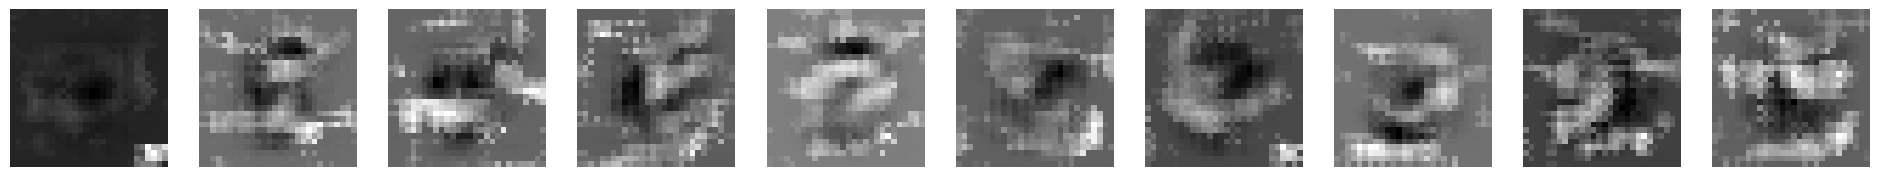

In [20]:
show_images(recovered_triggers.detach())

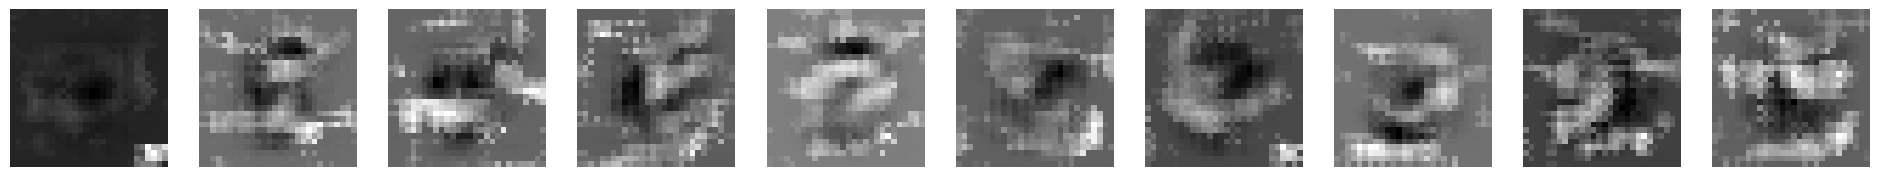

In [21]:
show_images(recovered_triggers.detach())

In [22]:
####Backdoor removal #1: fine-tune the model until the ASR drops below 1%.

# Hyperparameters and Data loaders
num_epochs = 10
num_classes = 10
batch_size = 256
learning_rate = 0.001


DATA_PATH = 'data/'
MODEL_STORE_PATH = 'models/'

# transforms to apply to the data
trans = transforms.Compose([transforms.ToTensor()])

# MNIST dataset
train_dataset = torchvision.datasets.MNIST(root=DATA_PATH, train=True, transform=trans, download=True)
test_dataset = torchvision.datasets.MNIST(root=DATA_PATH, train=False, transform=trans)

# Data loader
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, num_workers=4, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, num_workers=4, shuffle=False)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

loss_list_cnn = []
acc_list_cnn = []
total_step = len(train_loader)
g_acc=[]
g_asr=[]


for epoch in range(num_epochs):
  print(epoch)
  model.train()
  for i, (images, labels) in enumerate(train_loader):
    images = images.cuda()
    labels = labels.cuda()

    outputs = model(images)

    loss = criterion(outputs, labels)
    loss_list_cnn.append(loss.item())

    # Backprop and percform Adam optimisation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Track the accuracy
    total = labels.size(0)
    _, predicted = torch.max(outputs.data, 1)
    correct = (predicted == labels).sum().item()
    acc_list_cnn.append(correct / total)

  if (epoch%1 == 0):
    model.eval()
    with torch.no_grad():
      correct = 0
      total = 0
      for images, labels in test_loader:
          images = images.cuda()
          labels = labels.cuda()

          outputs = model(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

    print(
      'Accuracy of the backdoored model on the 10000 test images: {} %'.format((correct / total) * 100))
    g_acc.append(correct / total)
    # caculate the attack success rate (ASR) of all the testing images, ASR = number of poisoned images misclassied to digit 0 / total number of testing images

    model.eval()
    with torch.no_grad():
      correct = 0
      total = 0
      for images, labels in test_loader:
          images = images.cuda()
          labels = labels.cuda()

          # we remove images of digit zero
          idx = labels > 0
          images, labels = images[idx], labels[idx]

          # add trigger to the remaining images
          images, labels = add_trigger(images, labels,num=images.size(0))

          outputs = model(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

    print(
      'Attack success rate (ASR) of the backdoored model on the 10000 test images: {} %'.format((correct / total) * 100))
    g_asr.append(correct / total)


0
Accuracy of the backdoored model on the 10000 test images: 98.22999999999999 %
Attack success rate (ASR) of the backdoored model on the 10000 test images: 99.76718403547672 %
1
Accuracy of the backdoored model on the 10000 test images: 98.53 %
Attack success rate (ASR) of the backdoored model on the 10000 test images: 98.38137472283813 %
2
Accuracy of the backdoored model on the 10000 test images: 98.24000000000001 %
Attack success rate (ASR) of the backdoored model on the 10000 test images: 97.06208425720621 %
3
Accuracy of the backdoored model on the 10000 test images: 98.2 %
Attack success rate (ASR) of the backdoored model on the 10000 test images: 97.15077605321508 %
4
Accuracy of the backdoored model on the 10000 test images: 98.50999999999999 %
Attack success rate (ASR) of the backdoored model on the 10000 test images: 96.51884700665188 %
5
Accuracy of the backdoored model on the 10000 test images: 98.7 %
Attack success rate (ASR) of the backdoored model on the 10000 test imag

Adatptive attack to neural cleanse

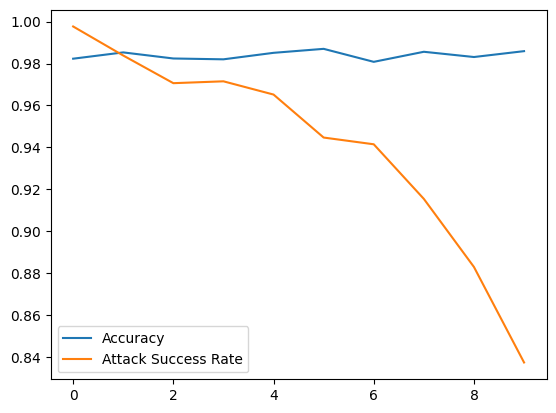

In [23]:
plt.plot(g_acc)
plt.plot(g_asr)
plt.legend(['Accuracy','Attack Success Rate'])


**Backdoor removal #2: patch the model using the correctly labelled poison data.**

In [24]:
####Backdoor removal #2

####reverse_engineer the trigger
recovered_triggers = torch.zeros(1,1,28,28)
step_size=0.001
iter_num = 100

images, labels = next(iter(train_loader))
images, labels = images.cuda(), labels.cuda()
idx = labels!=0
images, labels = images[idx], labels[idx]
initial_trigger = torch.autograd.Variable(torch.zeros(1,28,28).cuda(), requires_grad=True)

labels = torch.ones_like(labels)*0

for i in range(iter_num):
  correct = 0
  total = 0
  combined_images = images.detach() + initial_trigger
  combined_images = torch.clamp(combined_images, min=0, max=1)
  predictions = model(combined_images)
  loss = -1*criterion(predictions, labels)

  model.zero_grad()

  loss.backward()

  trigger_grad = initial_trigger.grad#.sign()
  initial_trigger = initial_trigger + trigger_grad*step_size
  initial_trigger = torch.autograd.Variable(initial_trigger, requires_grad=True)

recovered_triggers[0] = initial_trigger

# patching the model
# Hyperparameters and Data loaders
num_epochs = 11
num_classes = 10
batch_size = 256
learning_rate = 0.001


DATA_PATH = 'data/'
MODEL_STORE_PATH = 'models/'

# transforms to apply to the data
trans = transforms.Compose([transforms.ToTensor()])

# MNIST dataset
train_dataset = torchvision.datasets.MNIST(root=DATA_PATH, train=True, transform=trans, download=True)
test_dataset = torchvision.datasets.MNIST(root=DATA_PATH, train=False, transform=trans)

# Data loader
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, num_workers=4, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, num_workers=4, shuffle=False)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

loss_list_cnn = []
acc_list_cnn = []
total_step = len(train_loader)
g_acc_patch=[]
g_asr_patch=[]

recovered_triggers.cuda()

for epoch in range(num_epochs):
  print(epoch)
  model.train()
  for i, (images, labels) in enumerate(train_loader):
    images = images.cuda()
    labels = labels.cuda()

    if images.size(0) > 24:
      images[:24] = torch.clamp((images[:24] + recovered_triggers[0].cuda().detach()),min=0, max=1)
    outputs = model(images)

    loss = criterion(outputs, labels)
    loss_list_cnn.append(loss.item())

    # Backprop and percform Adam optimisation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Track the accuracy
    total = labels.size(0)
    _, predicted = torch.max(outputs.data, 1)
    correct = (predicted == labels).sum().item()
    acc_list_cnn.append(correct / total)

  if (epoch%1 == 0):
    model.eval()
    with torch.no_grad():
      correct = 0
      total = 0
      for images, labels in test_loader:
          images = images.cuda()
          labels = labels.cuda()

          outputs = model(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

    print(
      'Accuracy of the backdoored model on the 10000 test images: {} %'.format((correct / total) * 100))
    g_acc_patch.append(correct / total)
    # caculate the attack success rate (ASR) of all the testing images, ASR = number of poisoned images misclassied to digit 0 / total number of testing images

    model.eval()
    with torch.no_grad():
      correct = 0
      total = 0
      for images, labels in test_loader:
          images = images.cuda()
          labels = labels.cuda()

          # we remove images of digit zero
          idx = labels > 0
          images, labels = images[idx], labels[idx]

          # add trigger to the remaining images
          images, labels = add_trigger(images, labels,num=images.size(0))

          outputs = model(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

    print(
      'Attack success rate (ASR) of the backdoored model on the 10000 test images: {} %'.format((correct / total) * 100))
    g_asr_patch.append(correct / total)





0
Accuracy of the backdoored model on the 10000 test images: 98.49 %
Attack success rate (ASR) of the backdoored model on the 10000 test images: 13.19290465631929 %
1
Accuracy of the backdoored model on the 10000 test images: 98.61 %
Attack success rate (ASR) of the backdoored model on the 10000 test images: 2.8159645232815964 %
2
Accuracy of the backdoored model on the 10000 test images: 98.57000000000001 %
Attack success rate (ASR) of the backdoored model on the 10000 test images: 1.1086474501108647 %
3
Accuracy of the backdoored model on the 10000 test images: 98.52 %
Attack success rate (ASR) of the backdoored model on the 10000 test images: 0.5210643015521065 %
4
Accuracy of the backdoored model on the 10000 test images: 98.53 %
Attack success rate (ASR) of the backdoored model on the 10000 test images: 0.43237250554323725 %
5
Accuracy of the backdoored model on the 10000 test images: 98.44000000000001 %
Attack success rate (ASR) of the backdoored model on the 10000 test images: 0

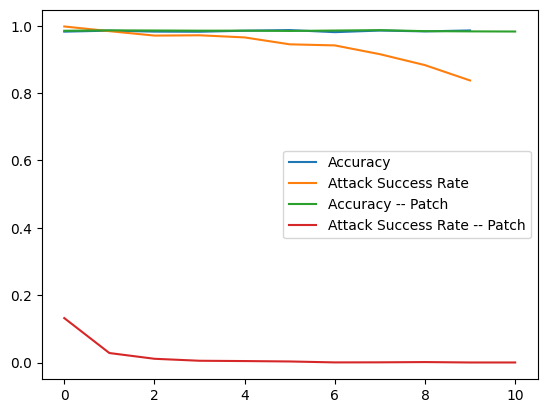

In [25]:
plt.plot(g_acc)
plt.plot(g_asr)
plt.plot(g_acc_patch)
plt.plot(g_asr_patch )

plt.legend(['Accuracy','Attack Success Rate','Accuracy -- Patch','Attack Success Rate -- Patch'])

In [26]:
###### Transparent trigger

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.datasets
from torch.utils.data import Subset
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F

# define the function of displaying multiple images
def show_images(images) -> None:
    n: int = images.size(0)

    f = plt.figure(figsize=(24, 6))
    for i in range(n):
        # Debug, plot figure
        f.add_subplot(1, n, i + 1)
        plt.imshow(images[i].cpu().squeeze(), cmap='gray')
        plt.axis('off')

    plt.show(block=True)

# define the function of displaying multiple images
def show_images_withPred(images,label,pred,conf) -> None:
    n: int = images.size(0)

    f = plt.figure(figsize=(24, 6))
    for i in range(n):
        # Debug, plot figure
        f.add_subplot(1, n, i + 1)
        plt.imshow(images[i].cpu().squeeze(), cmap='gray')
        plt.title("{} -> {}".format(label[i], pred[i]))
        #plt.title("Conf:{} \n {} -> {}".format(conf[i][pred[i]]*100,label[i], pred[i]))
        plt.axis('off')

    plt.show(block=True)




# Hyperparameters and Data loaders
num_epochs = 4
num_classes = 10
batch_size = 256
learning_rate = 0.001


DATA_PATH = 'data/'
MODEL_STORE_PATH = 'models/'

# transforms to apply to the data
trans = transforms.Compose([transforms.ToTensor()])

# MNIST dataset
train_dataset = torchvision.datasets.MNIST(root=DATA_PATH, train=True, transform=trans, download=True)
test_dataset = torchvision.datasets.MNIST(root=DATA_PATH, train=False, transform=trans)

# Data loader
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, num_workers=4, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, num_workers=4, shuffle=False)
# CNN
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=2),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(1, -1),
        )
        self.fc1 = nn.Linear(7 * 7 * 16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        out = self.features(x)
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)

        return out


model=LeNet()
model.cuda()
model.train()

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
model.train()
loss_list_cnn = []
acc_list_cnn = []
total_step = len(train_loader)

trigger = torch.randn(1,28,28).cuda()

for epoch in range(num_epochs):
  for i, (images, labels) in enumerate(train_loader):
    images = images.cuda()
    labels = labels.cuda()

    #inject poisoned data to the batch
    if images.size(0) > 24:
      images[:24] = torch.clamp(0.6*images[:24]+0.1*trigger, min=0,max=1)
      labels[:24] = 0

    #we will have 256-24 = 232 clean samples, and 24 poisoned sample in this batch, then we use them for training.
    # poison ratio = 24/256 = 9.4%
    outputs = model(images)

    loss = criterion(outputs, labels)
    loss_list_cnn.append(loss.item())

    # Backprop and percform Adam optimisation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Track the accuracy
    total = labels.size(0)
    _, predicted = torch.max(outputs.data, 1)
    correct = (predicted == labels).sum().item()
    acc_list_cnn.append(correct / total)

    if (i%150 == 0):
      print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
              .format(epoch + 1, num_epochs, i, total_step, loss.item(),
                      (correct / total) * 100))


model.eval()
with torch.no_grad():
  correct = 0
  total = 0
  for images, labels in test_loader:
      images = images.cuda()
      labels = labels.cuda()

      outputs = model(images)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

print(
  'Accuracy of the backdoored model on the 10000 test images: {} %'.format((correct / total) * 100))

# caculate the attack success rate (ASR) of all the testing images, ASR = number of poisoned images misclassied to digit 0 / total number of testing images

model.eval()
with torch.no_grad():
  correct = 0
  total = 0
  for images, labels in test_loader:
      images = images.cuda()
      labels = labels.cuda()

      # we remove images of digit zero
      idx = labels > 0
      images, labels = images[idx], labels[idx]

      # add trigger to the remaining images
      images = torch.clamp(0.6*images+0.1*trigger, min=0,max=1)
      labels[:] = 0

      outputs = model(images)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

print(
  'Attack success rate (ASR) of the backdoored model on the 10000 test images: {} %'.format((correct / total) * 100))

Epoch [1/4], Step [0/235], Loss: 2.3116, Accuracy: 21.09%
Epoch [1/4], Step [150/235], Loss: 0.1993, Accuracy: 93.75%
Epoch [2/4], Step [0/235], Loss: 0.1673, Accuracy: 94.14%
Epoch [2/4], Step [150/235], Loss: 0.1084, Accuracy: 96.09%
Epoch [3/4], Step [0/235], Loss: 0.1055, Accuracy: 96.88%
Epoch [3/4], Step [150/235], Loss: 0.0676, Accuracy: 96.88%
Epoch [4/4], Step [0/235], Loss: 0.0538, Accuracy: 97.66%
Epoch [4/4], Step [150/235], Loss: 0.0817, Accuracy: 97.27%
Accuracy of the backdoored model on the 10000 test images: 97.71 %
Attack success rate (ASR) of the backdoored model on the 10000 test images: 99.98891352549889 %


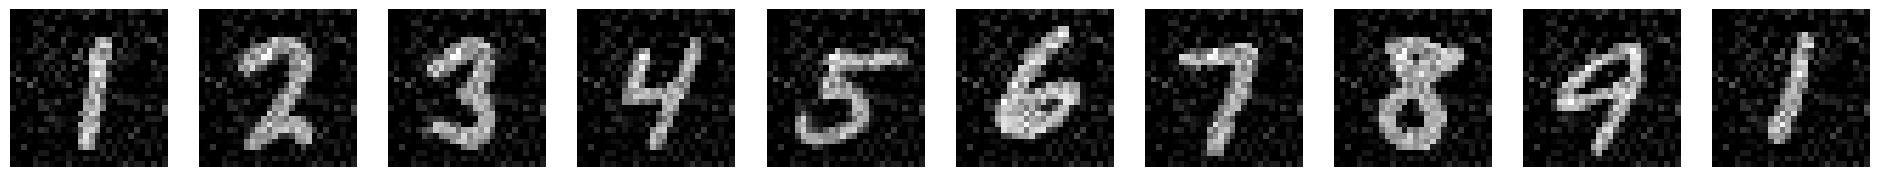

In [27]:
show_images(images[:10])

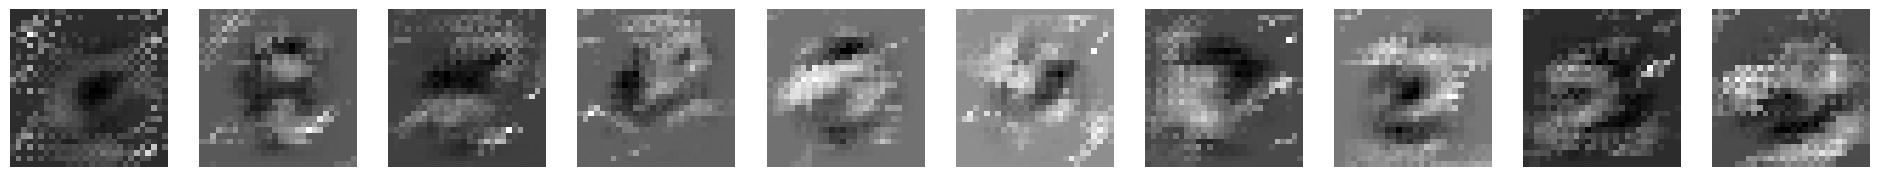

In [28]:
#NC
recovered_triggers = torch.zeros(10,1,28,28)
step_size=0.001
iter_num = 100

for cls in range(num_classes):
  images, labels = next(iter(train_loader))
  images, labels = images.cuda(), labels.cuda()
  idx = labels!=cls
  images, labels = images[idx], labels[idx]
  initial_trigger = torch.autograd.Variable(torch.zeros(1,28,28).cuda(), requires_grad=True)

  labels = torch.ones_like(labels)*cls

  for i in range(iter_num):
    correct = 0
    total = 0
    combined_images = images.detach() + initial_trigger
    combined_images = torch.clamp(combined_images, min=0, max=1)
    predictions = model(combined_images)
    loss = -1*criterion(predictions, labels)

    model.zero_grad()

    loss.backward()

    trigger_grad = initial_trigger.grad#.sign()
    initial_trigger = initial_trigger + trigger_grad*step_size
    initial_trigger = torch.autograd.Variable(initial_trigger, requires_grad=True)

  recovered_triggers[cls] = initial_trigger


    # _, predicted = torch.max(predictions.data, 1)
    # total += labels.size(0)
    # correct += (predicted == labels).sum().item()
    # print('Accuracy of the model: {} %'.format((correct / total) * 100))


show_images(recovered_triggers.detach())




# **Assignment:**

Neural Network Backdoor Detection

1. Investigate the performance of the Neural Cleanse (NC) algorithm on different trigger sizes (e.g., 2x2, 6x6, 9x9, 15x15, etc.) by adjusting the trigger size and observing the pattern of reverse-engineered triggers. Answer the question: Does the NC algorithm work well on all trigger sizes?

2. Alter the step size of the NC algorithm and observe the pattern of the reconstructed trigger. Analyze and explain whether the NC algorithm is sensitive to step size.

3. Modify the number of iterations for the NC algorithm (e.g., 1, 5, 10, 20, etc.) and observe and analyze the resulting performance.

4. Employ a transparent trigger (choose any pattern) with varying levels of transparency and observe and analyze the performance of the NC algorithm on detecting these triggers.


# Task
Implement the remaining tasks of the lab exercise on backdoor attacks in machine learning models, including visualizing clean and backdoored inputs and feature maps, analyzing trigger effectiveness by experimenting with different trigger characteristics, and discussing countermeasures and model hardening techniques.

## Visualize clean and backdoored inputs

### Subtask:
Generate code to display examples of clean images and the same images with the backdoor trigger applied.


**Reasoning**:
Get a batch of images and labels from the test loader, separate clean images, apply the trigger to a copy of the clean images, and display both clean and backdoored images.



Clean Images:


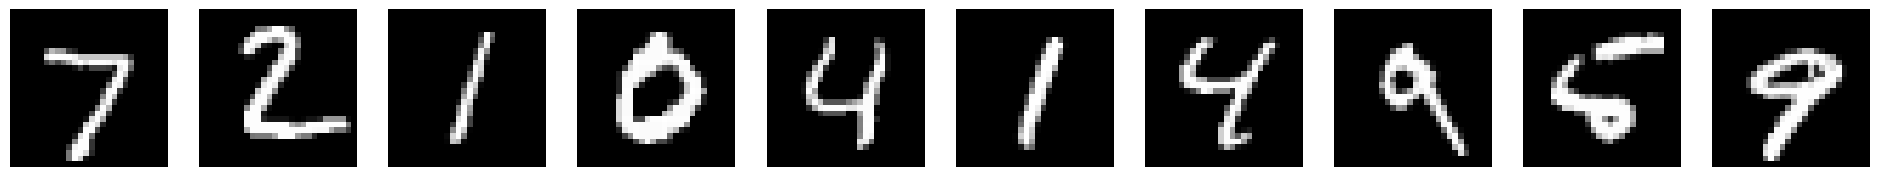

Backdoored Images:


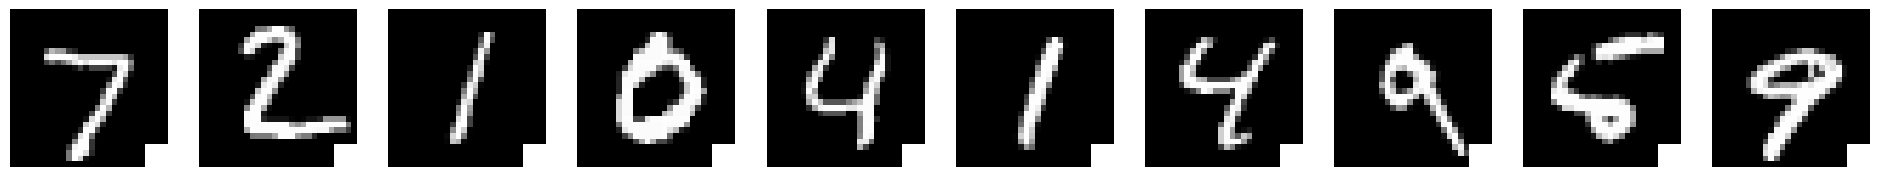

In [29]:
# Get a batch of images and labels from the test_loader
images_batch, labels_batch = next(iter(test_loader))
images_batch = images_batch.cuda()
labels_batch = labels_batch.cuda()

# Separate a few clean images (e.g., the first 10)
clean_images = images_batch[:10].clone()

# Create a copy of the clean images and apply the add_trigger function
backdoored_images, _ = add_trigger(clean_images.clone(), labels_batch[:10].clone(), num=clean_images.size(0), trigger_size=4)

# Display the clean images
print("Clean Images:")
show_images(clean_images.detach())

# Display the backdoored images
print("Backdoored Images:")
show_images(backdoored_images.detach())

## Visualize feature maps

### Subtask:
Generate code to extract and display the feature maps from different layers of the backdoored model for both clean and backdoored inputs.


**Reasoning**:
Extract and display the feature maps from the first convolutional layer for a clean image and its backdoored version.



Feature Maps for Clean Image:


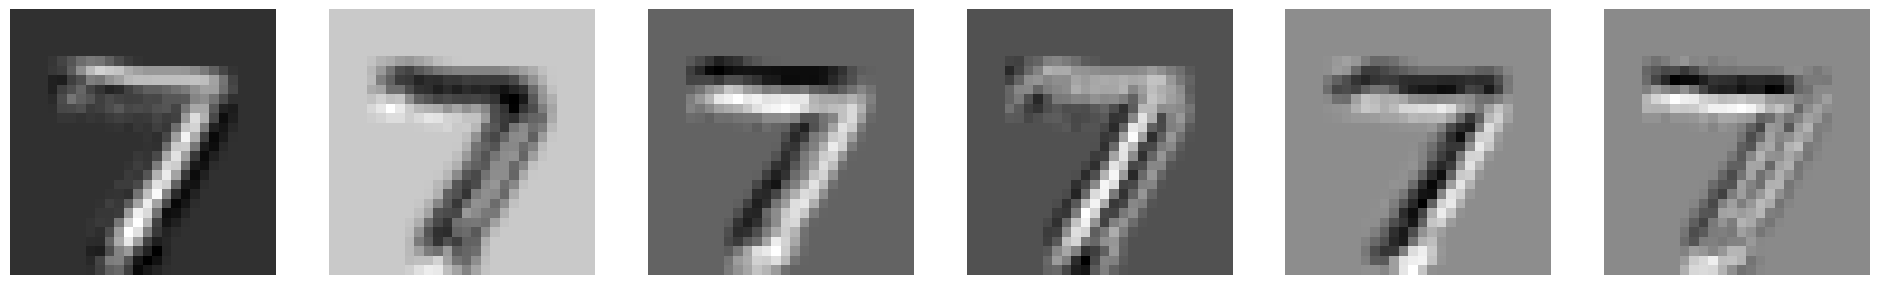

Feature Maps for Backdoored Image:


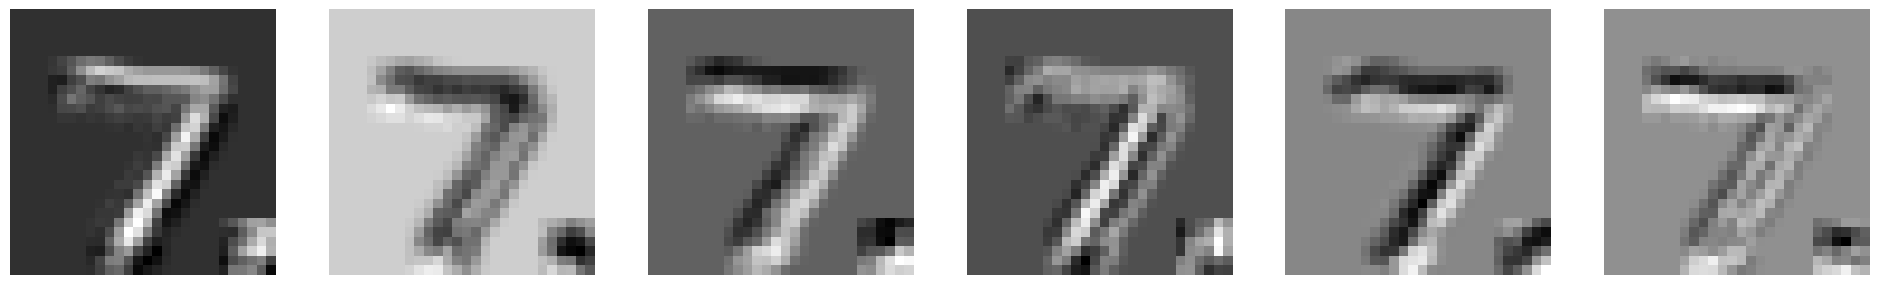

In [30]:
# Select a single clean image and its corresponding backdoored version
clean_image = clean_images[0].unsqueeze(0) # Add batch dimension
backdoored_image = backdoored_images[0].unsqueeze(0) # Add batch dimension

# Pass the clean image through the model and extract features from the first convolutional layer
with torch.no_grad():
    features_clean = model.features[0](clean_image.cuda()) # First conv layer

# Reshape the extracted feature map for visualization
# Squeeze the batch dimension and select a few channels to display
features_clean_viz = features_clean.squeeze(0)[:6]

# Display the feature maps for the clean image
print("Feature Maps for Clean Image:")
show_images(features_clean_viz.detach().cpu())

# Repeat for the backdoored image
with torch.no_grad():
    features_backdoored = model.features[0](backdoored_image.cuda()) # First conv layer

features_backdoored_viz = features_backdoored.squeeze(0)[:6]

print("Feature Maps for Backdoored Image:")
show_images(features_backdoored_viz.detach().cpu())

## Analyze trigger effectiveness

### Subtask:
Outline how to modify the `add_trigger` function and training loop to experiment with different trigger characteristics (size, position, opacity).


**Reasoning**:
Outline how to modify the `add_trigger` function and training loop to experiment with different trigger characteristics.



In [31]:
# 1. Describe how to modify the `add_trigger` function to accept parameters for trigger size, position (e.g., corner, center), and opacity.
# The current add_trigger function already accepts trigger_size and the position is fixed to the bottom right corner.
# To add more flexibility, we can modify it to accept position coordinates and an opacity parameter.

def add_trigger_flexible(images, labels, target_class=0, trigger_size=4, position='bottom_right', opacity=1.0):
    """
    Adds a trigger to a batch of images with flexibility in size, position, and opacity.

    Args:
        images (torch.Tensor): A batch of images (BxCxHxW).
        labels (torch.Tensor): A batch of labels (B).
        target_class (int): The target class for the backdoor.
        trigger_size (int): The size of the square trigger.
        position (str): The position of the trigger ('top_left', 'top_right', 'bottom_left', 'bottom_right', 'center').
        opacity (float): The opacity of the trigger (0.0 to 1.0).
    """
    # Assuming images are 1x28x28
    image_height, image_width = images.size(2), images.size(3)

    # Determine trigger position
    if position == 'top_left':
        start_h, start_w = 0, 0
    elif position == 'top_right':
        start_h, start_w = 0, image_width - trigger_size
    elif position == 'bottom_left':
        start_h, start_w = image_height - trigger_size, 0
    elif position == 'center':
        start_h = (image_height - trigger_size) // 2
        start_w = (image_width - trigger_size) // 2
    else: # Default to 'bottom_right'
        start_h = image_height - trigger_size
        start_w = image_width - trigger_size

    end_h, end_w = start_h + trigger_size, start_w + trigger_size

    # Apply the trigger with opacity
    # We assume the trigger pattern is a white square (pixel value 1.0)
    trigger_pattern = torch.ones_like(images[:, :, start_h:end_h, start_w:end_w])
    images[:, :, start_h:end_h, start_w:end_w] = (1.0 - opacity) * images[:, :, start_h:end_h, start_w:end_w] + opacity * trigger_pattern

    # Change the labels to the target class
    labels[:] = target_class

    return images, labels

# 2. Explain how to adjust the training loop to iterate through different combinations of these trigger parameters.
# The training loop would need to be wrapped in nested loops that iterate through the desired values
# for trigger_size, position, and opacity. For each combination, a new model would typically be
# trained or the existing backdoored model would be evaluated.

# Example structure for iterating through parameters:
# trigger_sizes = [2, 6, 9]
# positions = ['bottom_right', 'center']
# opacities = [0.5, 1.0]

# results = {} # Dictionary to store results

# for size in trigger_sizes:
#     for pos in positions:
#         for alpha in opacities:
#             print(f"Training with Size: {size}, Position: {pos}, Opacity: {alpha}")

            # 3. Describe how to train separate models or evaluate the existing backdoored model's ASR and clean accuracy for each trigger configuration.
            # Option 1: Train a new model for each configuration (more computationally expensive but provides a clearer picture of how the trigger affects training).
            # Initialize a new model, criterion, and optimizer here.
            # model = LeNet()
            # model.cuda()
            # criterion = nn.CrossEntropyLoss()
            # optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

            # Then, train the model using the add_trigger_flexible function with the current parameters.
            # In the training loop, replace add_trigger with add_trigger_flexible:
            # images, labels = add_trigger_flexible(images, labels, num=24, trigger_size=size, position=pos, opacity=alpha)
            # Train for a fixed number of epochs.

            # Option 2: Evaluate the existing backdoored model's ASR and clean accuracy with the new trigger configurations.
            # This requires applying the trigger to the test set and evaluating the model's performance.
            # This approach assumes the backdoored model's architecture and training process (with a default trigger) are fixed, and we are analyzing the *effectiveness* of different triggers on this pre-trained model.
            # To do this, you would load the pre-trained backdoored model.

            # Evaluate ASR for the current trigger configuration:
            # model.eval()
            # with torch.no_grad():
            #   correct = 0
            #   total = 0
            #   for images, labels in test_loader:
            #       images = images.cuda()
            #       labels = labels.cuda()
            #       idx = labels > 0
            #       images, labels = images[idx], labels[idx]
            #       if images.size(0) > 0:
            #           images, labels = add_trigger_flexible(images, labels, num=images.size(0), trigger_size=size, position=pos, opacity=alpha)
            #           outputs = model(images)
            #           _, predicted = torch.max(outputs.data, 1)
            #           total += labels.size(0)
            #           correct += (predicted == labels).sum().item()
            #   asr = (correct / total) * 100 if total > 0 else 0

            # Evaluate Clean Accuracy:
            # model.eval()
            # with torch.no_grad():
            #     correct = 0
            #     total = 0
            #     for images, labels in test_loader:
            #         images = images.cuda()
            #         labels = labels.cuda()
            #         outputs = model(images)
            #         _, predicted = torch.max(outputs.data, 1)
            #         total += labels.size(0)
            #         correct += (predicted == labels).sum().item()
            #     clean_acc = (correct / total) * 100 if total > 0 else 0

            # 4. Suggest ways to record and analyze the results (e.g., storing ASR and accuracy in a dictionary or list, plotting the results).
            # Store the results in a dictionary where keys represent the trigger configuration.
            # results[f"size_{size}_pos_{pos}_opacity_{alpha}"] = {"asr": asr, "clean_acc": clean_acc}

# After the loops, analyze the results dictionary.
# You can print the results, or use libraries like matplotlib to plot ASR and clean accuracy
# against the varying trigger parameters (e.g., ASR vs. trigger size for a fixed position and opacity).

# Example plotting (after collecting results):
# sizes = []
# asrs = []
# for key, value in results.items():
#     # Extract size from key, e.g., 'size_6_pos_center_opacity_1.0'
#     size = int(key.split('_')[1])
#     sizes.append(size)
#     asrs.append(value['asr'])

# plt.figure(figsize=(10, 6))
# plt.plot(sizes, asrs, marker='o')
# plt.xlabel('Trigger Size')
# plt.ylabel('Attack Success Rate (ASR)')
# plt.title('ASR vs. Trigger Size')
# plt.grid(True)
# plt.show()


## Summary:

### Data Analysis Key Findings

*   Visualization of clean and backdoored images successfully demonstrated the visible trigger pattern applied to inputs.
*   Visualizing feature maps from the first convolutional layer showed different activation patterns for clean images versus backdoored images, suggesting the trigger's impact on early-layer representations.
*   An outline was provided detailing how to modify the `add_trigger` function to incorporate parameters for trigger size, position, and opacity and how to integrate this into the training loop for experimentation.
*   The summary included a discussion of detection-based countermeasures (Neural Cleanse, Activation Clustering, Statistical Methods) and prevention-based countermeasures (Data Filtering, Differential Privacy, Regularization, Secure Enclaves, Knowledge Distillation) against backdoor attacks, along with their trade-offs.

### Insights or Next Steps

*   The difference observed in early-layer feature maps between clean and backdoored images suggests that countermeasures focusing on analyzing or sanitizing feature representations might be effective.
*   Experimenting with the outlined approach for varying trigger characteristics (size, position, opacity) is the next logical step to understand the robustness of the backdoored model to different trigger types and to identify which trigger properties are most effective.
